In [8]:
import pandas as pd
import numpy as np
import sys 
import scipy.io
from scipy.stats import kurtosis
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
sys.path.append("/home/bruce1996/data/Yi-Fung-Chuang/")
sys.path.append("/home/bruce1996/tools/SVDD-Python/")
from skfeature.function.similarity_based import lap_score
from skfeature.utility import construct_W
from src.BaseSVDD import BaseSVDD
from microbiome_preprocessing import split_tax,filter_taxa_by_prevalence,relative_abundance,add_taxa_name,binary_anomaly_detection_scatter_plot

## MCI cohort

In [4]:
mci_taxtable = pd.read_csv("/home/bruce1996/data/Yi-Fung-Chuang/MCI/mci_taxtable.txt",sep = "\t",index_col = 0)
mci_otutable =pd.read_csv("/home/bruce1996/data/Yi-Fung-Chuang/MCI/mci_otutable.txt",sep = "\t",index_col = 0)
demographic = pd.read_csv("/home/bruce1996/data/Yi-Fung-Chuang/MCI/demographic.txt",sep = "\t",index_col = 0)

In [5]:
mci_taxtable = mci_taxtable.drop("sp3866")
mci_otutable = mci_otutable.drop("sp3866")
tt = add_taxa_name(mci_otutable,mci_taxtable)
mci_otutable.index = tt
mci_taxtable.index = tt
mci_otutable = relative_abundance(mci_otutable)
mci_otu,mci_tax = filter_taxa_by_prevalence(mci_otutable,mci_taxtable,1)

demographic =  demographic.sort_values(["MCI"])
sorted_idx = list(demographic.index)
mci_otu = mci_otu.reindex(columns = sorted_idx)

### Filter by Kurtosis measure

In [47]:
mci_array = mci_otu.to_numpy()
k = kurtosis(mci_array,axis=1,fisher=False)
k_idx = np.argpartition(k, 3)[-100:]
mci_array = mci_array[k_idx,:]

mci_health = mci_array[:,demographic["MCI"] == 0].T
mci_nohealth = mci_array[:,demographic['MCI'] == 1].T

### Filter by Lapalacian score

In [21]:
mci_array = mci_otu.to_numpy()
mci_array = mci_array.T 

kwargs_W = {"metric": "euclidean", "neighbor_mode": "knn", "weight_mode": "heat_kernel", "k": 5, 't': 1}
W = construct_W.construct_W(mci_array, **kwargs_W)
l_score = lap_score.lap_score(mci_array,W=W)
l_idx = lap_score.feature_ranking(l_score)
mci_l_array = mci_array[:,l_idx[0:100]]

mci_l_health = mci_l_array[demographic["MCI"] == 0,:]
mci_l_nohealth = mci_l_array[demographic["MCI"] == 1,:]

### Isolation forest

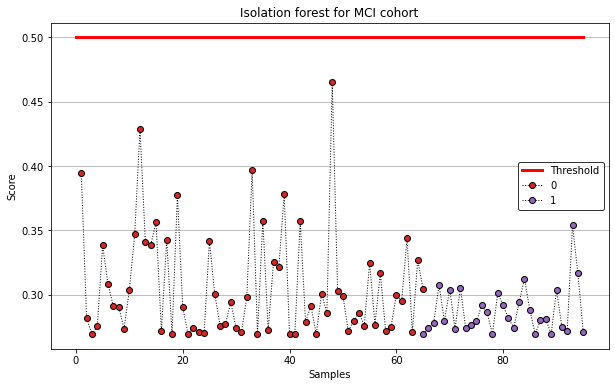

In [51]:
mci_if_fit = IsolationForest(random_state=0,).fit(mci_health)
mci_if_score = abs(mci_if_fit.score_samples(mci_array.T))
label = demographic["MCI"].values
binary_anomaly_detection_scatter_plot(0.5,mci_if_score,label,[0,1],
"/home/bruce1996/data/Yi-Fung-Chuang/one_class_classification/mci_isolation_filter_by_kurtosis_test.png",
"Isolation forest for MCI cohort")

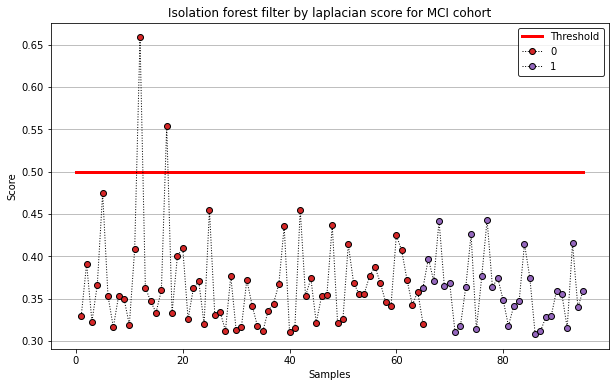

In [24]:
#filter by laplacian score
mci_if_fit = IsolationForest(random_state=0,).fit(mci_l_health)
mci_if_score = abs(mci_if_fit.score_samples(mci_l_array))
label = demographic["MCI"].values
binary_anomaly_detection_scatter_plot(0.5,mci_if_score,label,[0,1],
"/home/bruce1996/data/Yi-Fung-Chuang/one_class_classification/mci_isolation_filter_by_kurtosis_test.png",
"Isolation forest filter by laplacian score for MCI cohort")

### One class SVM

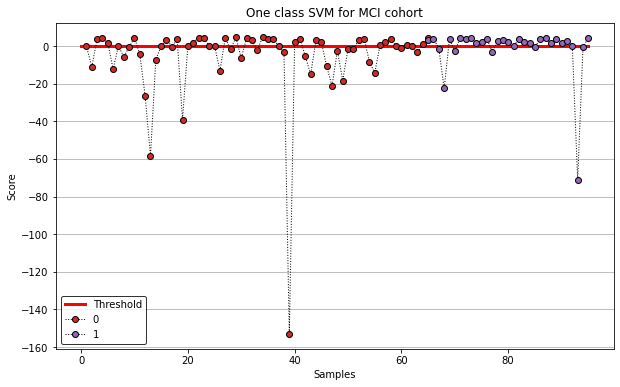

In [60]:
mci_ocsvm_fit = OneClassSVM(kernel='linear').fit(mci_health)
mci_ocsvm_score = mci_ocsvm_fit.decision_function(mci_array.T)
binary_anomaly_detection_scatter_plot(0,mci_ocsvm_score * -1,label,[0,1],
"/home/bruce1996/data/Yi-Fung-Chuang/one_class_classification/mci_ocsvm_filter_by_kurtosis_test.png",
"One class SVM for MCI cohort")

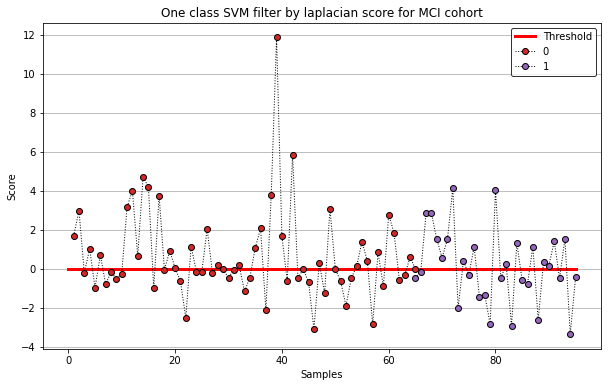

In [25]:
mci_ocsvm_fit = OneClassSVM(kernel='linear').fit(mci_l_health)
mci_ocsvm_score = mci_ocsvm_fit.decision_function(mci_l_array)
binary_anomaly_detection_scatter_plot(0,mci_ocsvm_score * -1,label,[0,1],
"/home/bruce1996/data/Yi-Fung-Chuang/one_class_classification/mci_ocsvm_filter_by_kurtosis_test.png",
"One class SVM filter by laplacian score for MCI cohort")

### SVDD



*** Fitting of the SVDD model is completed. ***

running time         = 0.0097 seconds
kernel function      = rbf
iterations           = 9
number of samples    = 65
number of features   = 100
number of SVs        = 32
ratio of SVs         = 49.2308 %
accuracy             = 55.3846 %




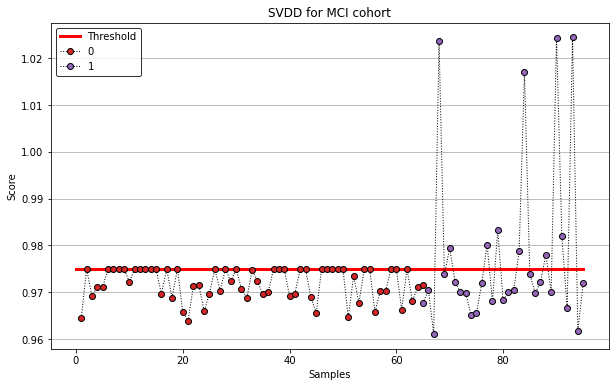

In [90]:
mci_svdd = BaseSVDD(C=0.9, gamma=0.3, kernel='rbf')
mci_svdd.fit(mci_health)
radius = mci_svdd.radius
distance = mci_svdd.get_distance(mci_array.T)
label = demographic["MCI"].values
binary_anomaly_detection_scatter_plot(radius,distance.A1,label,[0,1],
"/home/bruce1996/data/Yi-Fung-Chuang/one_class_classification/mci_svdd_filter_by_kurtosis.png",
"SVDD for MCI cohort")



*** Fitting of the SVDD model is completed. ***

running time         = 0.0109 seconds
kernel function      = rbf
iterations           = 10
number of samples    = 65
number of features   = 100
number of SVs        = 12
ratio of SVs         = 18.4615 %
accuracy             = 83.0769 %




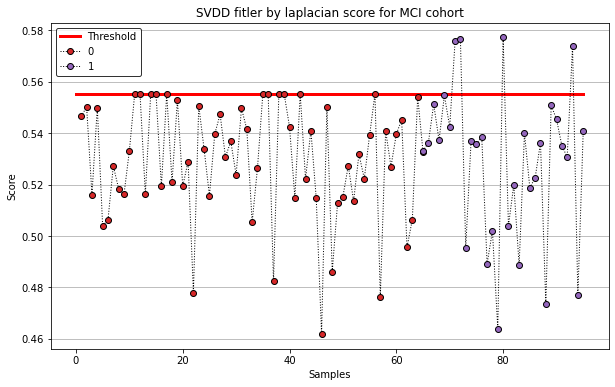

In [27]:
#filter by laplacian score 
mci_svdd = BaseSVDD(C=0.9, gamma=0.3, kernel='rbf')
mci_svdd.fit(mci_l_health)
radius = mci_svdd.radius
distance = mci_svdd.get_distance(mci_l_array)
label = demographic["MCI"].values
binary_anomaly_detection_scatter_plot(radius,distance.A1,label,[0,1],
"/home/bruce1996/data/Yi-Fung-Chuang/one_class_classification/mci_svdd_filter_by_kurtosis.png",
"SVDD fitler by laplacian score for MCI cohort")



*** Prediction of the provided data is completed. ***

running time         = 0.0026 seconds
number of samples    = 96
number of alarm      = 39


0.5833333333333334


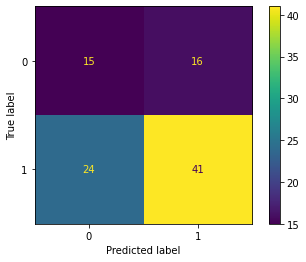

In [140]:
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
predict = mci_svdd.predict(mci_array.T)
predict = predict.A1
predict = predict.astype(int)
label = demographic["MCI"].values
mci_label = label
mci_label[mci_label == 1] = -1
mci_label[mci_label == 0] = 1
acc = accuracy_score(mci_label.astype(int), predict)
print(acc)
cm = confusion_matrix(mci_label.astype(int), predict)
cm_display = ConfusionMatrixDisplay(cm).plot()


## AVCD cohort

In [ ]:
path = "/home/bruce1996/data/Yi-Fung-Chuang/GMHI/mpa/merge_sample.mpa"
ab_table,tax_table = split_tax(path)
ab_table = ab_table.drop("NCBI_tax_id",1)
otu_table,tax_table = filter_taxa_by_prevalence(ab_table,tax_table,1)

avcd_label = pd.read_csv("/data/bruce/GMHI/PRJEB21528/sample_label.txt",sep = "\t",header=None,index_col = 0)
avcd_label.columns = ["Status"]
avcd_label = avcd_label.sort_values(["Status"])
sorted_idx = list(avcd_label.index)
avcd_otu = otu_table.reindex(columns = sorted_idx)

In [ ]:
avcd_array = avcd_otu.to_numpy()
k = kurtosis(avcd_array,axis=1,fisher=False)
k_idx = np.argpartition(k, 3)[-100:]
avcd_array = avcd_array[k_idx,:]

avcd_health = avcd_array[:,avcd_label["Status"] == "Healthy"].T
avcd_nohealth = avcd_array[:,avcd_label["Status"] == "Non-healthy"].T

### Isolation forest

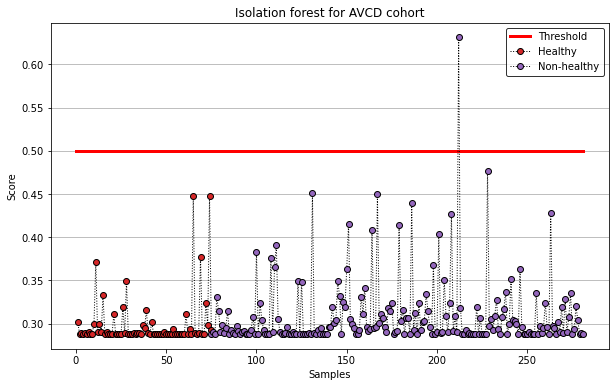

In [61]:
avcd_if_fit = IsolationForest(random_state=0,).fit(avcd_nohealth)
avcd_if_score = abs(avcd_if_fit.score_samples(avcd_array.T))
label = avcd_label["Status"].values
binary_anomaly_detection_scatter_plot(0.5,avcd_if_score,label,["Healthy","Non-healthy"],
"/home/bruce1996/data/Yi-Fung-Chuang/one_class_classification/avcd_isolation_filter_by_kurtosis.png",
"Isolation forest for AVCD cohort")

### One class SVM

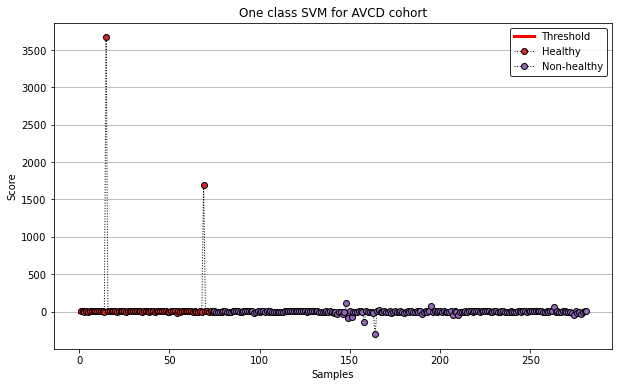

In [66]:

avcd_ocsvm_fit = OneClassSVM(kernel='linear').fit(avcd_nohealth)
avcd_ocsvm_score = avcd_ocsvm_fit.decision_function(avcd_array.T)
binary_anomaly_detection_scatter_plot(0,avcd_ocsvm_score * -1,label,["Healthy","Non-healthy"],
"/home/bruce1996/data/Yi-Fung-Chuang/one_class_classification/avcd_ocsvm_filter_by_kurtosis.png",
"One class SVM for AVCD cohort")


### SVDD



*** Fitting of the SVDD model is completed. ***

running time         = 0.0240 seconds
kernel function      = rbf
iterations           = 11
number of samples    = 207
number of features   = 100
number of SVs        = 46
ratio of SVs         = 22.2222 %
accuracy             = 80.1932 %




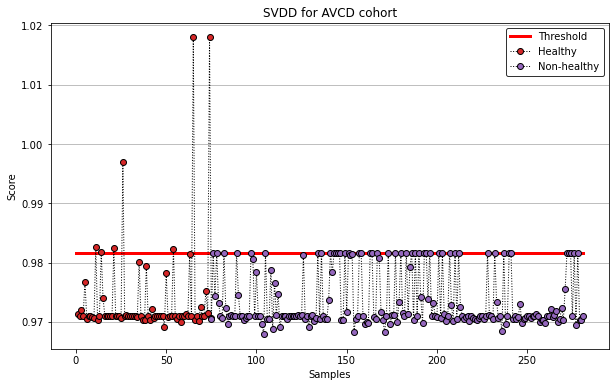

In [92]:
avcd_svdd = BaseSVDD(C=0.9, gamma=0.3, kernel='rbf')
avcd_svdd.fit(avcd_nohealth)
radius = avcd_svdd.radius
distance = avcd_svdd.get_distance(avcd_array.T)
label = avcd_label["Status"].values
binary_anomaly_detection_scatter_plot(radius,distance.A1,label,["Healthy","Non-healthy"],
"/home/bruce1996/data/Yi-Fung-Chuang/one_class_classification/avcd_svdd_filter_by_kurtosis.png",
"SVDD for AVCD cohort")